## Neural network to predict muon signal for individual showers

In [2]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

C:\Users\jfcre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
np.random.seed(11)

In [4]:
# Columns: Run, E_proton, E_iron, Zen, Q400, MuonVEM, nMuon, Type
# Note that right now, nMuon is useless
data = np.load('./data/NN_data_400m.npy')

In [5]:
# convert the python 2 bytes into python 3 format
data_ = []
for i in range(len(data)):
    data_.append([])
    for j in range(0,7):
        data_[i].append(float(data[i,j]))
data = np.array(data_)

In [6]:
# look at data logE in (16.0,16.5) and cos(zenith) > 0.9
data_ = []
for shower in data:
    E_proton = shower[1]
    E_iron = shower[2]
    E_avg = np.sqrt(E_proton*E_iron) # geometric mean
    logE = np.log10(E_avg)
    zen = shower[3]
    if logE >= 16 and logE <= 16.5 and np.cos(zen) > 0.9:
        data_.append(shower[1:])
data_trimmed = np.array(data_)

In [7]:
print(len(data_trimmed))

1462


In [8]:
# split into input and target
X = data_trimmed[:,0:4]
Y = data_trimmed[:,4]

In [9]:
# split the data into test and training set
x_train, x_test, y_train, y_test = train_test_split(X,Y)

In [10]:
# normalize the data because the network will be sensitive
# to relative magnitudes
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
# apply the scaler to the sets
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [12]:
# create model
model1 = Sequential()
model1.add(Dense(4,input_dim=4,activation='relu'))
model1.add(Dense(4,activation='relu'))
model1.add(Dense(1,activation=None))

In [13]:
# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model1.compile(loss='msle',optimizer='adam',metrics=['mape','mse'])

In [14]:
# fit the model to the data
history1 = model1.fit(x_train,y_train,epochs=75,batch_size=10)

Epoch 1/75
1096/1096 [==============================] - 1s 549us/step - loss: 4.6079 - mean_absolute_percentage_error: 94.4340 - mean_squared_error: 170.4063
Epoch 2/75
1096/1096 [==============================] - 0s 163us/step - loss: 3.2503 - mean_absolute_percentage_error: 86.3266 - mean_squared_error: 156.3725
Epoch 3/75
1096/1096 [==============================] - 0s 186us/step - loss: 2.1681 - mean_absolute_percentage_error: 77.6259 - mean_squared_error: 138.5960
Epoch 4/75
1096/1096 [==============================] - 0s 185us/step - loss: 1.5017 - mean_absolute_percentage_error: 72.7004 - mean_squared_error: 121.1316
Epoch 5/75
1096/1096 [==============================] - 0s 193us/step - loss: 1.0109 - mean_absolute_percentage_error: 69.4719 - mean_squared_error: 101.3040
Epoch 6/75
1096/1096 [==============================] - 0s 183us/step - loss: 0.6844 - mean_absolute_percentage_error: 66.5876 - mean_squared_error: 81.6674
Epoch 7/75
1096/1096 [==============================]

1096/1096 [==============================] - 0s 184us/step - loss: 0.0673 - mean_absolute_percentage_error: 23.9255 - mean_squared_error: 11.4737
Epoch 53/75
1096/1096 [==============================] - 0s 182us/step - loss: 0.0672 - mean_absolute_percentage_error: 24.2209 - mean_squared_error: 11.4123
Epoch 54/75
1096/1096 [==============================] - 0s 178us/step - loss: 0.0672 - mean_absolute_percentage_error: 23.9011 - mean_squared_error: 11.5099
Epoch 55/75
1096/1096 [==============================] - 0s 181us/step - loss: 0.0671 - mean_absolute_percentage_error: 24.1538 - mean_squared_error: 11.3513
Epoch 56/75
1096/1096 [==============================] - 0s 180us/step - loss: 0.0670 - mean_absolute_percentage_error: 23.9827 - mean_squared_error: 11.4511
Epoch 57/75
1096/1096 [==============================] - 0s 182us/step - loss: 0.0669 - mean_absolute_percentage_error: 23.9202 - mean_squared_error: 11.4070
Epoch 58/75
1096/1096 [==============================] - 0s 179u

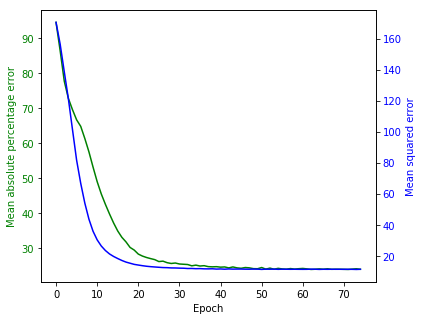

In [15]:
# plot the metrics vs epoch number

fig1,ax1 = plt.subplots(1,1,figsize=(6,5))
ax1.plot(history1.history['mean_absolute_percentage_error'],color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean absolute percentage error',color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax1_ = ax1.twinx()
ax1_.plot(history1.history['mean_squared_error'],color='blue')
ax1_.set_ylabel('Mean squared error',color='blue')
ax1_.tick_params(axis='y', labelcolor='blue')
plt.show()

In [16]:
# use the model to make predictions
predictions1 = model1.predict(x_test)

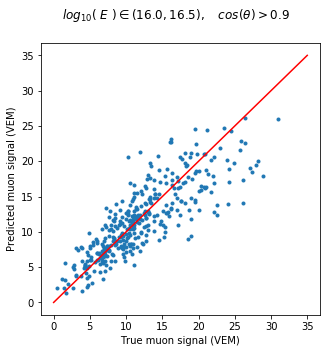

In [17]:
# plot predictions vs true values
fig2,ax2 = plt.subplots(1,1,figsize=(5,5))
ax2.scatter(y_test,predictions1,marker='.')
x = np.linspace(0,35)
ax2.plot(x,x,color='r')
ax2.set_xlabel('True muon signal (VEM)')
ax2.set_ylabel('Predicted muon signal (VEM)')
fig2.suptitle(r'$log_{10}(\ E\ ) \in (16.0,16.5),\quad cos(\theta) > 0.9$')
plt.show()

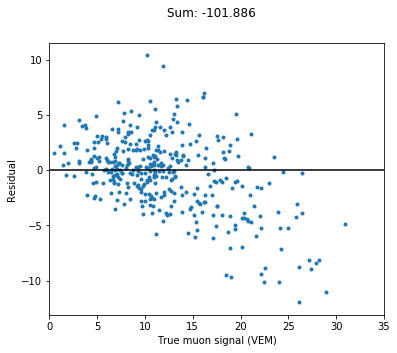

In [18]:
# Plot residuals
fig3,ax3=plt.subplots(1,1,figsize=(6,5))
residuals1 = [predictions1[i]-y_test[i] for i in range(len(y_test))]
ax3.scatter(y_test,residuals1,marker='.')
x = np.linspace(0,35)
ax3.plot(x,0*x,color='black')
ax3.set_xlim(0,35)
ax3.set_ylabel('Residual')
ax3.set_xlabel('True muon signal (VEM)')
fig3.suptitle("Sum: {0:.3f}".format(sum(residuals1)[0]))
plt.show()

#### A look at the whole data set

In [19]:
X2 = scaler.transform(X)

In [20]:
# use the model to make predictions
predictions2 = model1.predict(X2)

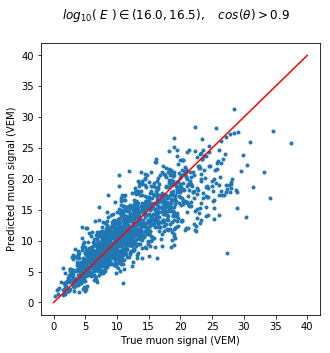

In [23]:
# plot predictions vs true values
fig4,ax4 = plt.subplots(1,1,figsize=(5,5))
ax4.scatter(Y,predictions2,marker='.')
x = np.linspace(0,40)
ax4.plot(x,x,color='r')
ax4.set_xlabel('True muon signal (VEM)')
ax4.set_ylabel('Predicted muon signal (VEM)')
fig4.suptitle(r'$log_{10}(\ E\ ) \in (16.0,16.5),\quad cos(\theta) > 0.9$')
plt.show()

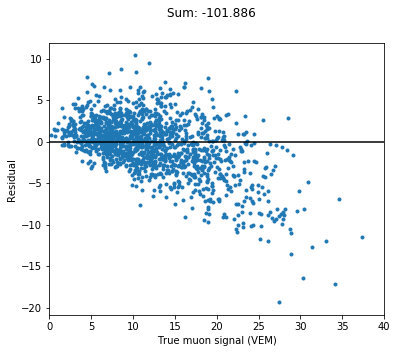

In [24]:
# Plot residuals
fig5,ax5=plt.subplots(1,1,figsize=(6,5))
residuals2 = [predictions2[i]-Y[i] for i in range(len(Y))]
ax5.scatter(Y,residuals2,marker='.')
x = np.linspace(0,40)
ax5.plot(x,0*x,color='black')
ax5.set_xlim(0,40)
ax5.set_ylabel('Residual')
ax5.set_xlabel('True muon signal (VEM)')
fig5.suptitle("Sum: {0:.3f}".format(sum(residuals1)[0]))
plt.show()